In [1]:
import os
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.4"

DATA_DIR = Path.cwd().parent / "data/rte"


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
from deeprte.dataset import (
    Split,
    load,
    convert_dataset,
    get_nest_dict_shape,
    preprocess_grid,
)

# _ = convert_dataset(DATA_DIR / "2d_RTE_e2.npz")


In [8]:
ds = load(
    Split.TRAIN_AND_VALID,
    is_training=True,
    batch_dims=[5, 10, 500],
    data_dir=DATA_DIR / "rte_2d_converted.npz",
)

ds.element_spec


Processing data, shapes are: {'sigma_t': (500, 40, 40), 'sigma_a': (500, 40, 40), 'psi_bc': (500, 40, 12), 'psi_label': (500, 40, 40, 24), 'phi': (500, 40, 40)}
Processing grid, shapes are: {'w_angle': (24,), 'v': (24, 2), 'r': (40, 40, 2), 'rv_prime': (40, 12, 4), 'w_prime': (40, 12)}


{'interior': (TensorSpec(shape=(None, 500, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 500, 2), dtype=tf.float32, name=None),
  F(x=TensorSpec(shape=(None, 1600, 2), dtype=tf.float32, name=None), y=TensorSpec(shape=(None, None, 1600, 2), dtype=tf.float32, name=None)),
  F(x=TensorSpec(shape=(None, 480, 4), dtype=tf.float32, name=None), y=TensorSpec(shape=(None, None, 480), dtype=tf.float32, name=None))),
 'label': TensorSpec(shape=(None, None, 500), dtype=tf.float32, name=None)}

In [9]:
from deeprte.dataset import get_nest_dict_shape

for d in ds.take(1):
    print(get_nest_dict_shape(d))
    r, v = d["interior"][0], d["interior"][1]
    print(np.sum((r[1] - r[0]) ** 2))
    print(np.sum((v[1] - v[0]) ** 2))


{'interior': (TensorShape([5, 500, 2]), TensorShape([5, 500, 2]), F(x=TensorShape([5, 1600, 2]), y=TensorShape([5, 10, 1600, 2])), F(x=TensorShape([5, 480, 4]), y=TensorShape([5, 10, 480]))), 'label': TensorShape([5, 10, 500])}
0.0
0.0


In [3]:
from deeprte.utils import get_model_haiku_params, flat_dict_to_rte_data

params = get_model_haiku_params("rte_2d_1", DATA_DIR)

with np.load(DATA_DIR / "rte_2d_converted.npz") as npzfile:
    rte_data = flat_dict_to_rte_data(npzfile)

grid, num_grid_points = preprocess_grid(rte_data["grid"], is_training=False)
data = rte_data["data"]


In [4]:
get_nest_dict_shape(data), get_nest_dict_shape(grid)


({'sigma_t': (500, 40, 40),
  'sigma_a': (500, 40, 40),
  'psi_bc': (500, 40, 12),
  'psi_label': (500, 40, 40, 24),
  'phi': (500, 40, 40)},
 {'w_angle': (24,),
  'v': (24, 2),
  'r': (1600, 2),
  'rv_prime': (480, 4),
  'w_prime': (480,),
  'rv': (38400, 4)})

In [5]:
from deeprte.models.rte_op import RTEOperator
from deeprte.modules.green_fn import GreenFunction
from deeprte.typing import F
import ml_collections

config = ml_collections.ConfigDict(
    {
        "green_net": [128, 128, 128, 128, 1],
        "coeffs_net": {"weights": [64, 1], "coeffs": [64, 2]},
    }
)

sol = RTEOperator(config, GreenFunction)


In [9]:
import time

i = np.random.randint(500)


data_i = tf.nest.map_structure(lambda x: x[i : i + 1].reshape(1, -1), data)

psi_bc = data_i["psi_bc"]
sigma = np.stack([data_i["sigma_t"], data_i["sigma_a"]], axis=-1)
r, v, rv_prime, w_prime, w_angle = (
    grid["r"],
    grid["v"],
    grid["rv_prime"],
    grid["w_prime"],
    grid["w_angle"],
)

t_prev = time.time()
pred_rho = sol.rho(
    params, None, r, F(r, sigma), F(rv_prime, w_prime * psi_bc), (v, w_angle)
)
pred_rho.block_until_ready()
dt = time.time() - t_prev

print(dt)


0.8549814224243164


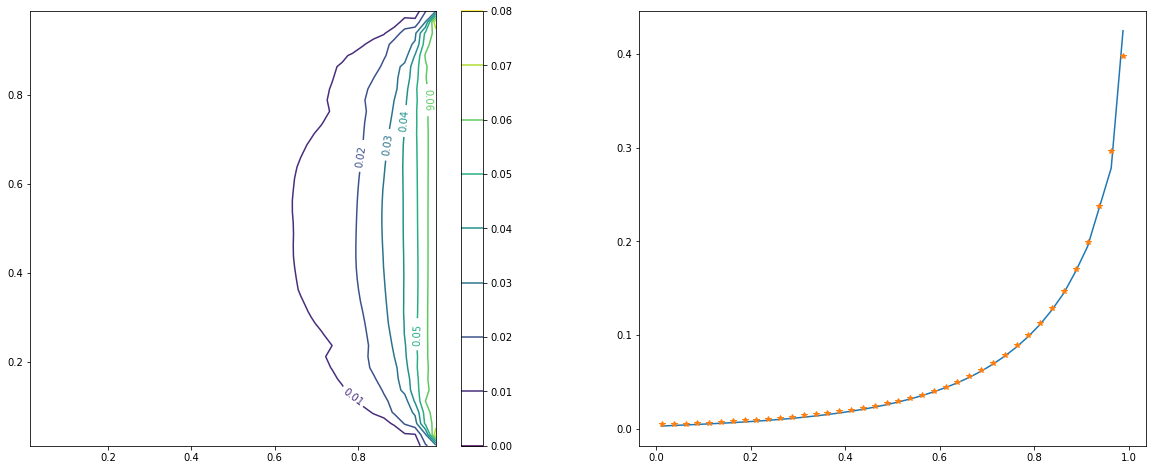

In [10]:
import matplotlib.pyplot as plt

pred_rho = pred_rho.reshape(-1, 40, 40).squeeze()
phi = data_i["phi"].reshape(40, 40)


fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

cs = axs[0].contour(
    r[..., 0].reshape(40, 40),
    r[..., 1].reshape(40, 40),
    np.abs(pred_rho - phi),
)
axs[0].clabel(cs, inline=True, fontsize=10)
fig.colorbar(cs, ax=axs[0])

axs[1].plot(
    r[..., 0].reshape(40, 40)[:, 0],
    phi[:, 0],
    r[..., 0].reshape(40, 40)[:, 0],
    pred_rho[:, 0],
    "*",
)

plt.show()
